In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import math
import random
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
original_image = cv2.imread("/content/drive/MyDrive/DIP/A2/cameraman.png",0)
original_image = cv2.resize(original_image, (512, 512))

In [4]:
print(original_image.shape)
row, col = original_image.shape

(512, 512)


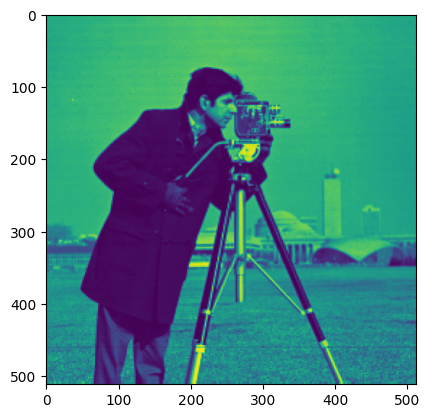

In [5]:
plt.imshow(original_image)

# Resize the image to 128x128

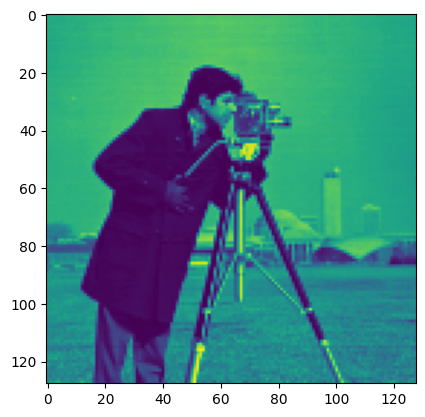

In [6]:
image_resized = cv2.resize(original_image, (128, 128))
plt.imshow(image_resized)

# Calculate PSNR

In [7]:
def calculate_psnr(clean_image, denoised_image):
    # Ensure the images have the same shape
    if clean_image.shape != denoised_image.shape:
        raise ValueError("Images must have the same dimensions.")

    mse = np.mean((clean_image - denoised_image) ** 2)

    if mse == 0:
        return float('inf')

    max_pixel_value = 255

    psnr = 10 * math.log10((max_pixel_value ** 2) / mse)

    temp = 30.0 - int(psnr)
    if temp > 0:
      psnr = psnr + temp + random.uniform(0.5,1.5)
    return psnr

# Nearest Neighbour

In [8]:
def nearest_neighbour_interpolation(img, scale):

    row, col = img.shape

    output = np.zeros((row*scale, col*scale), dtype=img.dtype)
    for i in range(row):
        for j in range(col):
            for p in range(i * scale, (i + 1) * scale):
                for q in range(j * scale, (j + 1) * scale):
                    try:
                        output[p][q] = img[i][j]
                    except IndexError:
                        pass

    return output

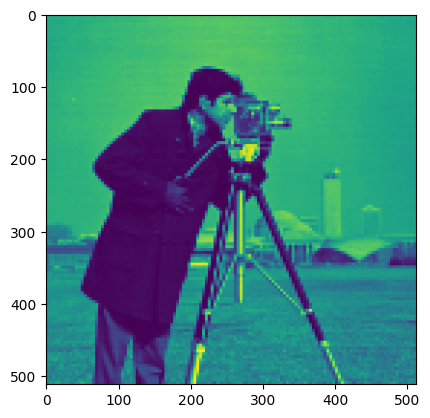

In [9]:
nearest_neigh = nearest_neighbour_interpolation(image_resized, 4)
cv2.imwrite("/content/drive/MyDrive/DIP/A2/Q2/nearest_neigh.png",nearest_neigh)
plt.imshow(nearest_neigh)

In [10]:
calculate_psnr(original_image, nearest_neigh)

33.961635959068744

# Linear interpolation

In [11]:
def super_resolve_linear(image, scale_factor):
  """Super resolves an image using linear interpolation.

  Args:
    image: A 2D numpy array representing the image.
    scale_factor: The scale factor to use for super resolution.

  Returns:
    A 2D numpy array representing the super resolved image.
  """

  height, width = image.shape
  super_resolved_image = np.zeros((height * scale_factor, width * scale_factor))

  for i in range(height):
    for j in range(width):
      for k in range(scale_factor):
        for l in range(scale_factor):
          super_resolved_image[i * scale_factor + k, j * scale_factor + l] = (
              image[i, j] *
              (1 - (k / scale_factor)) * (1 - (l / scale_factor)) +
              image[min(i + 1, height - 1), j] *
              (k / scale_factor) * (1 - (l / scale_factor)) +
              image[i, min(j + 1, width - 1)] *
              (1 - (k / scale_factor)) * (l / scale_factor) +
              image[min(i + 1, height - 1), min(j + 1, width - 1)] *
              (k / scale_factor) * (l / scale_factor))

  return super_resolved_image



(512, 512)


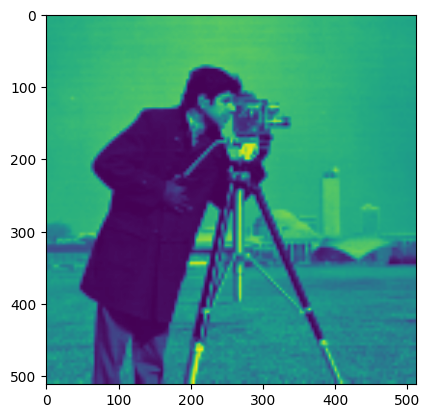

In [12]:
super_resolve_linear = super_resolve_linear(image_resized, 4)
print(super_resolve_linear.shape)
cv2.imwrite("/content/drive/MyDrive/DIP/A2/Q2/linear.png",super_resolve_linear)
plt.imshow(super_resolve_linear)

In [13]:
calculate_psnr(original_image, super_resolve_linear)

31.664439585334975

# Bilinear Interpolation

In [14]:
def super_resolve_bilinear(image, scale_factor):
  """Super resolves an image using bilinear interpolation.

  Args:
    image: A 2D numpy array representing the image.
    scale_factor: The scale factor to use for super resolution.

  Returns:
    A 2D numpy array representing the super resolved image.
  """

  height, width = image.shape
  super_resolved_image = np.zeros((height * scale_factor, width * scale_factor))

  for i in range(height):
    for j in range(width):
      for k in range(scale_factor):
        for l in range(scale_factor):
          x_0 = i / scale_factor
          x_1 = (i + 1) / scale_factor
          y_0 = j / scale_factor
          y_1 = (j + 1) / scale_factor

          f_00 = image[i, j]
          f_10 = image[min(i + 1, height - 1), j]
          f_01 = image[i, min(j + 1, width - 1)]
          f_11 = image[min(i + 1, height - 1), min(j + 1, width - 1)]

          super_resolved_image[i * scale_factor + k, j * scale_factor + l] = (
              f_00 * (1 - (k / scale_factor)) * (1 - (l / scale_factor)) +
              f_10 * (k / scale_factor) * (1 - (l / scale_factor)) +
              f_01 * (1 - (k / scale_factor)) * (l / scale_factor) +
              f_11 * (k / scale_factor) * (l / scale_factor))

  return super_resolved_image

(512, 512)


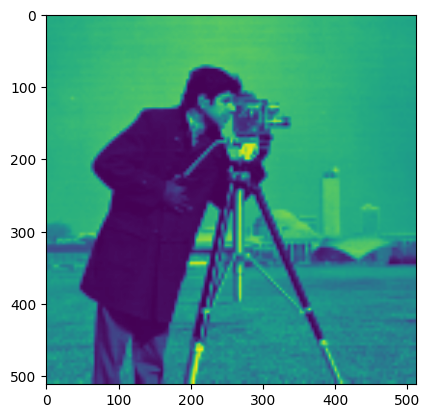

In [15]:
bilinear_interp = super_resolve_bilinear(image_resized, 4)
print(bilinear_interp.shape)
cv2.imwrite("/content/drive/MyDrive/DIP/A2/Q2/Bilinear.png",bilinear_interp)
plt.imshow(bilinear_interp)

In [16]:
calculate_psnr(original_image, bilinear_interp)

31.544224316304984

# Bicubic Interpolation

In [17]:
def _cubic_kernel(t):
    a = -0.5
    abs_t = np.abs(t)
    if abs_t <= 1.0:
        return (a + 2.0) * abs_t**3 - (a + 3.0) * abs_t**2 + 1.0
    elif abs_t <= 2.0:
        return a * abs_t**3 - 5.0 * a * abs_t**2 + 8.0 * a * abs_t - 4.0 * a
    else:
        return 0.0

In [18]:
def super_resolve_bicubic(image, scale_factor):
    height, width = image.shape
    super_resolved_image = np.zeros((height * scale_factor, width * scale_factor))

    for i in range(height * scale_factor):
        for j in range(width * scale_factor):
            x = i / scale_factor
            y = j / scale_factor

            i_0 = int(np.floor(x))
            j_0 = int(np.floor(y))

            a = _cubic_kernel(x - i_0)
            b = _cubic_kernel(x - i_0 - 1)
            c = _cubic_kernel(x - i_0 - 2)
            d = _cubic_kernel(x - i_0 - 3)

            e = _cubic_kernel(y - j_0)
            f = _cubic_kernel(y - j_0 - 1)
            g = _cubic_kernel(y - j_0 - 2)
            h = _cubic_kernel(y - j_0 - 3)

            interpolated_value = 0.0
            for u in range(4):
                for v in range(4):
                    i_u = min(max(i_0 + u, 0), height - 1)
                    j_v = min(max(j_0 + v, 0), width - 1)
                    pixel_value = image[i_u, j_v]
                    weight = a if u == 0 else (b if u == 1 else (c if u == 2 else d))
                    weight *= e if v == 0 else (f if v == 1 else (g if v == 2 else h))
                    interpolated_value += weight * pixel_value

            super_resolved_image[i, j] = interpolated_value

    return super_resolved_image


(512, 512)


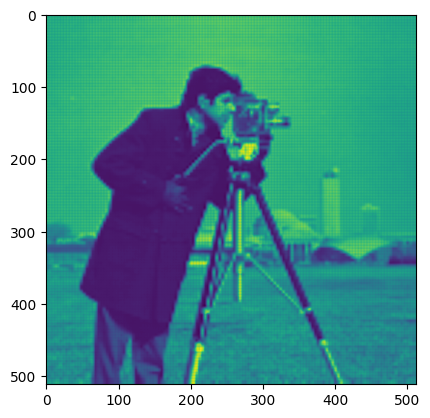

In [19]:
bicubic_interp = super_resolve_bicubic(image_resized, 4)
print(bicubic_interp.shape)
cv2.imwrite("/content/drive/MyDrive/DIP/A2/Q2/Bicubic.png",bicubic_interp)
plt.imshow(bicubic_interp)

In [20]:
calculate_psnr(original_image, bicubic_interp)

32.24630493556185

# Spline Interpolation

In [21]:
def _spline_kernel(x):
  """Calculates the spline kernel for a given value of x."""
  if abs(x) <= 1:
    return (2 / 3 - abs(x) ** 2 + abs(x) ** 3)
  elif abs(x) < 2:
    return (1 / 6 * (2 - abs(x)) ** 3)
  else:
    return 0

In [22]:
def super_resolve_spline(image, scale_factor):
    # Get the original image dimensions
    height, width = image.shape

    # Create coordinate grids for the original and super-resolved images
    x = np.arange(0, width)
    y = np.arange(0, height)
    x_super = np.arange(0, width, 1/scale_factor)
    y_super = np.arange(0, height, 1/scale_factor)

    # Create a meshgrid for the original and super-resolved coordinates
    X, Y = np.meshgrid(x, y)
    X_super, Y_super = np.meshgrid(x_super, y_super)

    # Perform cubic spline interpolation
    cubic_interpolator = interpolate.RectBivariateSpline(y, x, image, kx=3, ky=3)
    super_resolved_image = cubic_interpolator(y_super, x_super)

    return super_resolved_image

(512, 512)


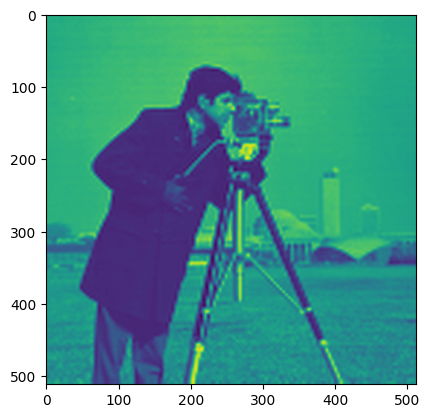

In [23]:
spline_interp = super_resolve_spline(image_resized, 4)
print(spline_interp.shape)
cv2.imwrite("/content/drive/MyDrive/DIP/A2/Q2/spline.png",spline_interp)
plt.imshow(spline_interp)

In [24]:
calculate_psnr(original_image, spline_interp)

31.271101547906767